### Retrieve soundings directly using python

This notebook uses the [wyominglib](https://github.com/phaustin/A405/blob/master/soundings/wyominglib.py) module, which parses  sounding data from [U. Wyoming](http://weather.uwyo.edu/upperair/sounding.html)
with [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/)

In [49]:
from importlib import reload
import soundings.wyominglib
reload(soundings.wyominglib)
from soundings.wyominglib import make_frames
import pandas as pd
from matplotlib import pyplot as plt
import requests
import datetime
from datetime import timezone as tz
import tzlocal   #pip install tzlocal
import h5py
from pprint import pformat
print(help(make_frames))

Help on function make_frames in module soundings.wyominglib:

make_frames(html_doc)
    input: web page from wyoming upperair sounding site
           http://weather.uwyo.edu/cgi-bin/sounding retrieved by
           the requests module
    output: attr_dict dictionary with ['header', 'site_id','longitude','latitude', 'elevation', 'units']
            sound_dict soudning dictionary with sounding times as keys and sounding as dataframes

None


### 1.  Form the url using a template with variable substitution from a dictionary

In [50]:
#this template holds the text that will always be the same,
# plus variables that will be substituted in based on dictionary values

url_template=("http://weather.uwyo.edu/cgi-bin/sounding?"
              "region={region:s}"
              "&TYPE=TEXT%3ALIST"
              "&YEAR={year:s}"
              "&MONTH={month:s}"
              "&FROM={start:s}"
              "&TO={stop:s}"
              "&STNM={station:s}")

#### Uncomment one of these dictionaries to get a set of soundings.  Dictionary values are inserted into the url_tempate to form the query url.  See wikipedia on [query strings](https://en.wikipedia.org/wiki/Query_string)

In [51]:
values=dict(region='samer',year='2015',month='2',start='0100',stop='2800',station='71925')
#values=dict(region='nz',year='2013',month='2',start='0100',stop='2800',station='93417')
#values=dict(region='naconf',year='2013',month='2',start='0100',stop='2800',station='71802')
#values=dict(region='ant',year='2013',month='07',start='0100',stop='2800',station='89009')
url=url_template.format_map(values)
print('here is the url we call to get the soundings: \n',url)

here is the url we call to get the soundings: 
 http://weather.uwyo.edu/cgi-bin/sounding?region=samer&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=2&FROM=0100&TO=2800&STNM=71925


### 2. Use the requests module to grab the web page

In [52]:
#
# Make do_web False to reuse a page for debugging
#
do_web = False
backup_file='backup.txt'
if do_web:
    #
    # grab the web page that is loaded with this url
    #
    html_doc = requests.get(url).text
    print('read {} bytes'.format(len(html_doc)))
    with open(backup_file,'w') as f:
        f.write(html_doc)
    if len(html_doc) < 2000:
        print('debug: short html_doc, something went wrong:',html_doc)
        #sys.exit(1)
else:
    with open(backup_file,'r') as f:
        html_doc=f.read()

### 3.  Parse the sounding page into two dictionaries

attr_dict holds attributes ['header', 'site_id','longitude','latitude', 'elevation', 'units']

sounding_dict holds the soundings indexed by datetime

In [53]:
attr_dict,sounding_dict = make_frames(html_doc)

header is:  71925 YCB Cambridge Bay Observations at 00Z 01 Feb 2015


### Create a timestamp and convert to UTC

In [54]:
mytz=tzlocal.get_localzone()
now=datetime.datetime.now(tz=mytz)
now=now.astimezone(tz.utc)
timestamp=now.strftime('%Y-%m-%d %H:%M:%S UTC')
print(timestamp)

2016-01-27 02:39:01 UTC


### Add history, query and timestamp attributes to the dictionary, and order the keys

In [55]:
attr_dict['timestamp']=timestamp
attr_dict['history']="written by test_requests.py"
attr_dict['query']= url
#
# write the keys out in this order
#
key_list=['header', 'site_id','longitude','latitude', 'elevation', 'units','history','query','timestamp']

### Use HDFStore to write the soundings out keyed by date

In [56]:
name = 'out.h5'    
with pd.HDFStore(name,'w') as store:
    for key,value in sounding_dict.items():
        #need to insert Y in front of the year because
        #h5py groups need to be legal python variables
        #(remove Y to see error message)
        thetime=key.strftime("Y%Y_%b_%d_%HZ")  
        store.put(thetime,value,format='table')

### Use h5py to store the attributes as metadata

In [57]:
with h5py.File(name,'a') as f:
        for key in key_list:
            print('writing key, value: ',key,attr_dict[key])
            f.attrs[key]=attr_dict[key]
        f.close()

writing key, value:  header 71925 YCB Cambridge Bay Observations at 00Z 01 Feb 2015
writing key, value:  site_id 71925
writing key, value:  longitude -105.06
writing key, value:  latitude 69.13
writing key, value:  elevation 2.0
writing key, value:  units hPa;m;C;C;%;g/kg;deg;knot;K;K;K
writing key, value:  history written by test_requests.py
writing key, value:  query http://weather.uwyo.edu/cgi-bin/sounding?region=samer&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=2&FROM=0100&TO=2800&STNM=71925
writing key, value:  timestamp 2016-01-27 02:39:01 UTC


### Show how to read the data and metadata back in

Need to trap IOError because there are 4 empty variables in the hdf file
that can't be read.  See [this discussion](https://github.com/h5py/h5py/issues/279)
about how to fix this in future h5py releases.

In [58]:
attributes={}
with h5py.File(name,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 2.0,
 'header': '71925 YCB Cambridge Bay Observations at 00Z 01 Feb 2015',
 'history': 'written by test_requests.py',
 'latitude': 69.129999999999995,
 'longitude': -105.06,
 'query': 'http://weather.uwyo.edu/cgi-bin/sounding?region=samer&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=2&FROM=0100&TO=2800&STNM=71925',
 'site_id': '71925',
 'timestamp': '2016-01-27 02:39:01 UTC',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}


In [59]:
name = 'out.h5'    
separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(name,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[0]]
print('{0:}sounding times:{1:}{0:} '.format(separator,times))
print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]
print('variables with units: \n',pformat(units_dict))


++++++++++++++++++++++++++++++
sounding times:['/Y2015_Feb_01_00Z', '/Y2015_Feb_02_00Z', '/Y2015_Feb_02_12Z', '/Y2015_Feb_03_00Z', '/Y2015_Feb_03_12Z', '/Y2015_Feb_04_00Z', '/Y2015_Feb_04_12Z', '/Y2015_Feb_05_00Z', '/Y2015_Feb_05_12Z', '/Y2015_Feb_06_00Z', '/Y2015_Feb_06_12Z', '/Y2015_Feb_07_00Z', '/Y2015_Feb_07_12Z', '/Y2015_Feb_08_00Z', '/Y2015_Feb_08_12Z', '/Y2015_Feb_09_00Z', '/Y2015_Feb_09_12Z', '/Y2015_Feb_10_00Z', '/Y2015_Feb_10_12Z', '/Y2015_Feb_11_00Z', '/Y2015_Feb_11_12Z', '/Y2015_Feb_12_00Z', '/Y2015_Feb_12_12Z', '/Y2015_Feb_13_00Z', '/Y2015_Feb_13_12Z', '/Y2015_Feb_14_00Z', '/Y2015_Feb_14_12Z', '/Y2015_Feb_15_00Z', '/Y2015_Feb_15_12Z', '/Y2015_Feb_16_00Z', '/Y2015_Feb_16_12Z', '/Y2015_Feb_17_00Z', '/Y2015_Feb_17_12Z', '/Y2015_Feb_18_00Z', '/Y2015_Feb_18_12Z', '/Y2015_Feb_20_00Z', '/Y2015_Feb_20_12Z', '/Y2015_Feb_21_00Z', '/Y2015_Feb_21_12Z', '/Y2015_Feb_22_00Z', '/Y2015_Feb_22_12Z', '/Y2015_Feb_23_00Z', '/Y2015_Feb_23_12Z', '/Y2015_Feb_24_00Z', '/Y2015_Feb_24_12Z', '/Y2015

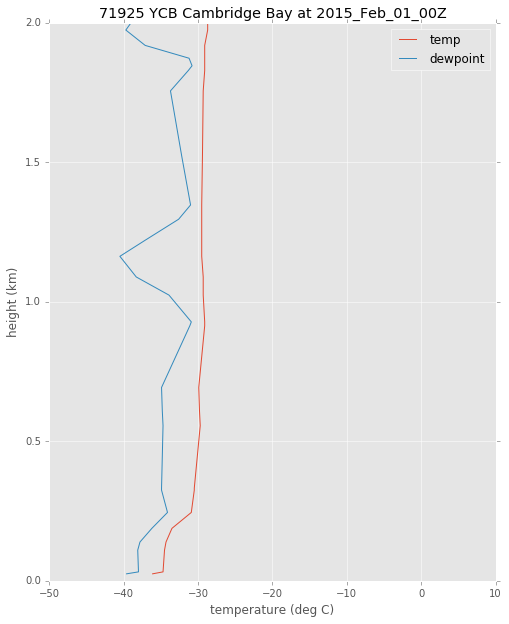

In [60]:
%matplotlib inline
key=times[3]  #pick the third sounding
the_sounding=sounding_dict[key]
m2km=1.e-3  #convert meters to km
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(8,10))
ax.plot(the_sounding['temp'],the_sounding['hght']*m2km,label='temp')
ax.plot(the_sounding['dwpt'],the_sounding['hght']*m2km,label='dewpoint')
ax.legend()
out=ax.set(xlabel="temperature (deg C)",ylabel="height (km)",
      title =title)
out=ax.set(ylim=[0,2],xlim=[-50,10])

Dew point temperature between /Y2015_Feb_01_00Z to /Y2015_Feb_28_00Z


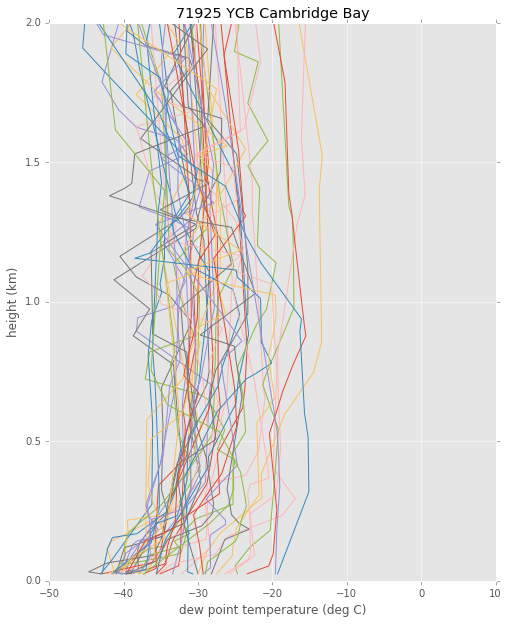

In [61]:
fig,ax=plt.subplots(1,1,figsize=(8,10))
for the_time in times:
    the_sound=sounding_dict[the_time]
    ax.plot(the_sound['dwpt'],the_sound['hght']*m2km)
out=ax.set(xlabel="dew point temperature (deg C)",ylabel="height (km)",
      title =location)
out=ax.set(ylim=[0,2],xlim=[-50,10])
print('Dew point temperature between {} to {}'.format(times[0],times[-1]))